<a href="https://colab.research.google.com/github/bwsi-hadr/2019-student-final-exercise/blob/master/Logistics_final_exercise_grid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
# need to specify location of some certificates for rasterio
!export CURL_CA_BUNDLE=/etc/ssl/certs/ca-certificates.crt
!sudo mkdir -p /etc/pki/tls/certs
!sudo cp /etc/ssl/certs/ca-certificates.crt /etc/pki/tls/certs/ca-bundle.crt
try:
  import rasterio
  import rasterio.plot
  import rasterio.merge 
  import rasterio.mask
except:
  !pip install rasterio
  import rasterio
  import rasterio.plot
  import rasterio.merge
  import rasterio.mask
  
try:
  import rasterstats as rs
except:
  !pip install rasterstats  
  import rasterstats as rs
  
try:
  import pyproj
except:
  !pip install pyproj
  import pyproj
  
import networkx as nx
try:
  import osmnx as ox
except:
  # osmnx depends on the system package libspatialindex
  !apt install libspatialindex-dev
  !pip install osmnx
  import osmnx as ox

try: 
  import geopandas as gpd
except: 
  !pip install geopandas 
  import geopandas as gpd
  
try:
  import contextily as ctx 
except:
  # install dependencies for contextily
  !apt install libproj-dev proj-data proj-bin
  !apt install libgeos-dev
  !pip install cython
  !pip install cartopy
  # install contextily
  !pip install contextily==1.0rc1 --no-use-pep517 --no-cache-dir
  import contextily as ctx
  
import fiona
from shapely.geometry import Point, LineString, Polygon
  
import gdal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/'My Drive'/BWSI-Remote-Sensing/'Final_exercise'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/BWSI-Remote-Sensing/Final_exercise


In [0]:
import csv
import json
import shapely
import itertools

In [5]:
!ls game_grid_export
pd.set_option('display.max_columns', 30)

facilities	      flooding.prj	       game_grid_all_stats.dbf
facilities_stats.csv  flooding.shp	       game_grid_all_stats.prj
flooding.cpg	      flooding.shx	       game_grid_all_stats.shp
flooding.dbf	      game_grid_all_stats.cpg  game_grid_all_stats.shx


In [6]:
!ls game_grid_export/facilities

airfields.cpg	 EMS.prj	    hospitals.shx    shelters.dbf
airfields.dbf	 EMS.shp	    local_eocs.cpg   shelters.prj
airfields.prj	 EMS.shx	    local_eocs.dbf   shelters.shp
airfields.shp	 fire_stations.cpg  local_eocs.prj   shelters.shx
airfields.shx	 fire_stations.dbf  local_eocs.shp   state_eocs.cpg
cell_towers.cpg  fire_stations.prj  local_eocs.shx   state_eocs.dbf
cell_towers.dbf  fire_stations.shp  powerplants.cpg  state_eocs.prj
cell_towers.prj  fire_stations.shx  powerplants.dbf  state_eocs.shp
cell_towers.shp  hospitals.cpg	    powerplants.prj  state_eocs.shx
cell_towers.shx  hospitals.dbf	    powerplants.shp
EMS.cpg		 hospitals.prj	    powerplants.shx
EMS.dbf		 hospitals.shp	    shelters.cpg


In [0]:
game_grid = gpd.read_file('game_grid_export/game_grid_all_stats.shp')
hospitals = gpd.read_file('game_grid_export/facilities/hospitals.shp')
flooding = gpd.read_file('game_grid_export/flooding.shp')
airfields = gpd.read_file('game_grid_export/facilities/airfields.shp')
fire_stations = gpd.read_file('game_grid_export/facilities/fire_stations.shp')
ems = gpd.read_file('game_grid_export/facilities/EMS.shp')
local_eocs = gpd.read_file('game_grid_export/facilities/local_eocs.shp')
powerplants = gpd.read_file('game_grid_export/facilities/powerplants.shp')
state_eocs = gpd.read_file('game_grid_export/facilities/state_eocs.shp')
shelters = gpd.read_file('game_grid_export/facilities/shelters.shp')
utils = gpd.read_file('../../game/results.shp')
cell_towers = gpd.read_file('game_grid_export/facilities/cell_towers.shp')
hospitals['Large'] = hospitals['BEDS']>=200
ems['Large'] = ems['TOTAL_VEHI']>=5
game_grid = game_grid.to_crs('EPSG:3785')
ax = fig.add_subplot(221)
flooding = flooding.to_crs(game_grid.crs)
hospitals = hospitals.to_crs(game_grid.crs)
shelters = shelters.to_crs(game_grid.crs)
airfields = airfields.to_crs(game_grid.crs)
fire_stations = fire_stations.to_crs(game_grid.crs)
powerplants = powerplants.to_crs(game_grid.crs)
ems = ems.to_crs(game_grid.crs)
cell_towers = cell_towers.to_crs(game_grid.crs)


In [0]:
fig = plt.figure(figsize=[20,20])
ax = fig.add_subplot(221)


ax2 = game_grid.plot(ax=ax,cmap='Greens',column='elevation')
flooding.plot(color='blue',ax=ax,zorder=2)
hospitals.plot(cmap='Wistia',ax=ax,zorder=3,column=(hospitals['Large']))
ems.plot(ax=ax)
ax3 = fig.add_subplot(222)
ax3g = game_grid.plot(ax=ax3)
ax4shelters = shelters.buffer(3000).plot(ax=ax3,color='yellow')
ax4 = cell_towers.buffer(20000).plot(ax=ax3,color='red',alpha=0.1)
ax5 = fig.add_subplot(223)
ax8 = game_grid.plot(ax=ax5,cmap='Greens',column='Transporta')
ax7 = airfields.plot(ax=ax5,color='red')
ax9 = hospitals.loc[hospitals['HELIPAD']=='Y'].plot(ax=ax5, color='yellow')
ax6 = fig.add_subplot(224)
ax10 = powerplants.buffer(20000).plot(ax=ax6,color='r',zorder=3,alpha=0.2)
ax11 = game_grid.plot(ax=ax6, column='Utility',legend=True)
ax12 = fire_stations.buffer(15000).plot(ax=ax6,color='g',zorder=5,alpha=0.1)
ax13 = hospitals.loc[hospitals['Large']].buffer(25000).plot(ax=ax, alpha=0.2)
ax14 = hospitals.loc[hospitals['Large'] == False].buffer(15000).plot(ax=ax, alpha=0.2)


In [0]:
airfields.loc[airfields['city']=='Taunton']

In [0]:
game_grid['eff util'] = 0
game_grid['eff health'] = 0
e = gpd.GeoDataFrame()
e['geometry'] = None
power_plants_squares = {}


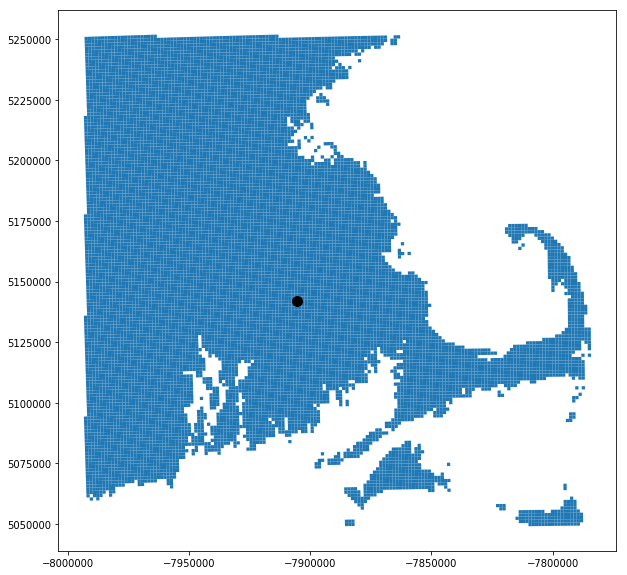

In [61]:
fig = plt.figure(figsize=[10,10])
base = airfields.loc[110]
ax = fig.add_subplot(111)
game_grid.plot(ax=ax,zorder=0)
ax.plot(base['geometry'].x, base['geometry'].y, color='BLACK',zorder=5,markersize=10,marker='o')


In [49]:
for idx, i in enumerate(powerplants['geometry'].buffer(25000)):
  e.loc[0, 'geometry'] = i
  m = gpd.sjoin(game_grid[game_grid['eff util'] > 9], e)
  power_plants_squares[idx] = set(m.index.to_list())
  m['util add'] = 3
  m = m.drop(labels=['kmSQ_ID', 'GZD', 'EASTING', 'NORTHING', 'MGRS_10km','Shape_Leng', 'Shape_Le_1', 'Shape_Area', 'x_centroid', 'y_centroid','elevation', 'population', 'Health', 'Utility', 'Transporta', 'index_right','geometry'],axis=1)
  game_grid['eff util'] += game_grid.merge(m,how='left',on='MGRS').fillna(0)['util add']
  m['util add'] = 0
game_grid.loc[game_grid['eff util']>10, 'eff util'] = 10
budget = 2000000
power_plants_squares_2 = power_plants_squares.copy()
squares_times = [0 for i in range(game_grid.shape[0])]
power_plant_indices = set()
while True:
  done = set()
  curr_max = max((len(v), k) for k,v in power_plants_squares_2.items())[1]
  for sq in power_plants_squares_2[curr_max]:
    squares_times[sq]+=1
    if squares_times[sq] == 3:
      done.add(sq)
  budget-=30000
  del power_plants_squares_2[curr_max]
  if budget < 0:
    break
  else:
    power_plant_indices.add(curr_max)

  for plant in power_plants_squares_2:
    new_set = power_plants_squares_2[plant] - done
    power_plants_squares_2[plant] = new_set
grid_util = game_grid
grid_util['eff util'] = 0
for idx, i in enumerate(powerplants.loc[power_plant_indices]['geometry'].buffer(25000)):
  e.loc[0, 'geometry'] = i
  m = gpd.sjoin(game_grid, e)
  power_plants_squares[idx] = set(m.index.to_list())
  m['util add'] = 3
  m = m.drop(labels=['kmSQ_ID', 'GZD', 'EASTING', 'NORTHING', 'MGRS_10km','Shape_Leng', 'Shape_Le_1', 'Shape_Area', 'x_centroid', 'y_centroid','elevation', 'population', 'Health', 'Utility', 'Transporta', 'index_right','geometry'],axis=1)
  grid_util['eff util'] += game_grid.merge(m,how='left',on='MGRS').fillna(0)['util add']
  m['util add'] = 0
grid_util.loc[grid_util['eff util']>10,'eff util'] = 10

print(power_plant_indices)

/usr/local/lib/python3.6/dist-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!(EPSG:3785 != None)
  '(%s != %s)' % (left_df.crs, right_df.crs))


{128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}


Total Amount of Resources Needed:

450 Fuel (Airfields)

12000 Fuel (Power Plants)



In [0]:
game_grid.to_file('../../game/results.shp')

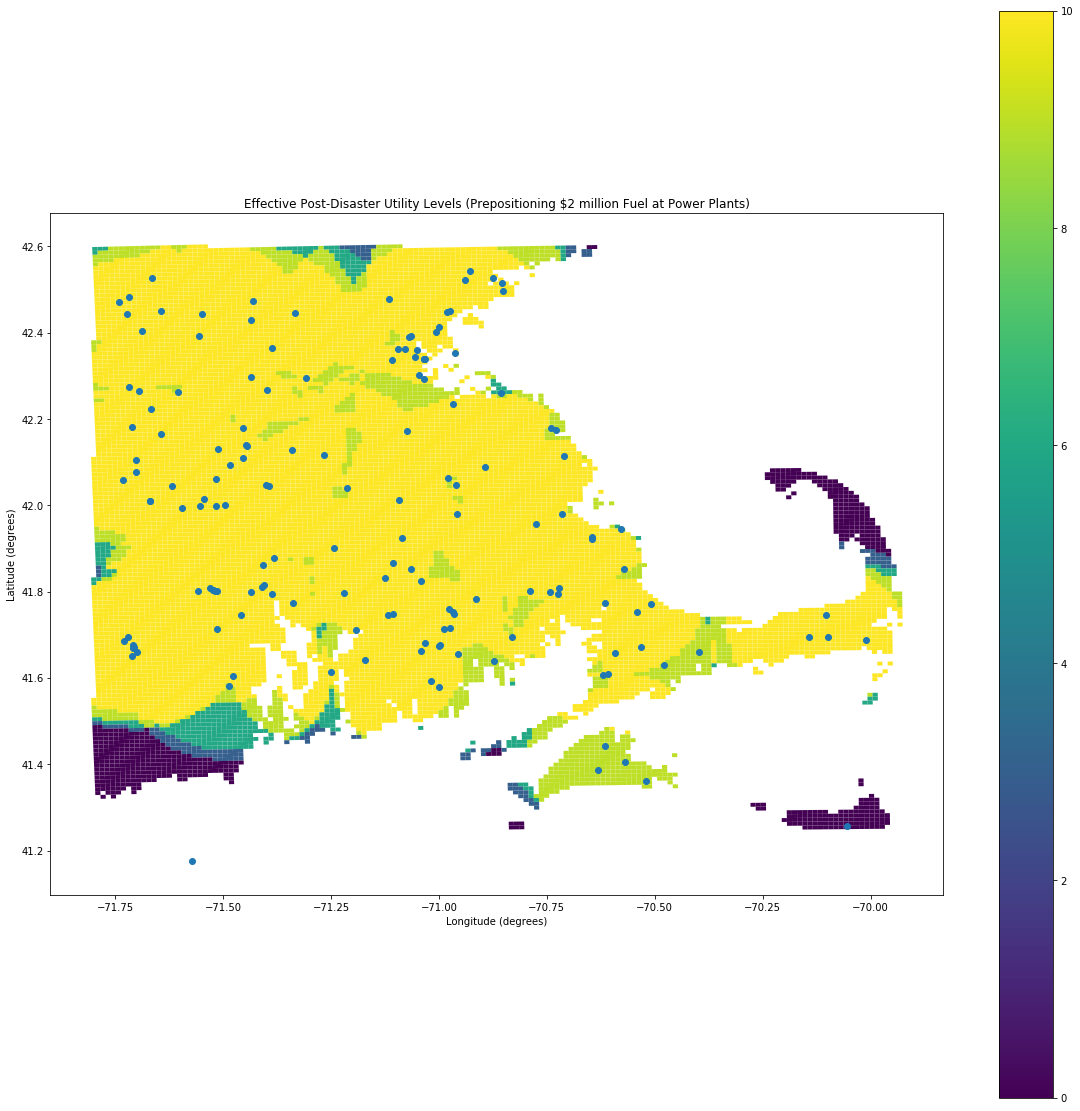

In [0]:
# transformation = osr.CoordinateTransformation(inp,out)
# transformation
fig = plt.figure(figsize=[20,20])
ax = fig.add_subplot(111)
ax1 = utils.to_crs(epsg=4326).plot(ax=ax,column='eff util',legend=True)
ax.set_title('Effective Post-Disaster Utility Levels (Prepositioning $2 million Fuel at Power Plants)')
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')
fig.set_facecolor('white')
ax2 = powerplants.to_crs(epsg=4326).plot(ax=ax)


In [0]:
fig = plt.figure(figsize=[20,20])
ax = fig.add_subplot(111)
ax1 = grid_util.plot(ax=ax,column='eff util',legend=True)
ax2 = fire_stations.buffer(15000).plot(ax=ax,color='red',zorder=5,alpha=0.1)
ax3 = hospitals.loc[hospitals['Large']].buffer(25000).plot(ax=ax,color='red',zorder=6,alpha=0.2)
ax4 = hospitals.loc[hospitals['Large'] == False].buffer(15000).plot(ax=ax,color='red',zorder=7,alpha=0.2)
ax5 = shelters.buffer(3000).plot(ax=ax,color='red',zorder=8,alpha=0.1)

In [0]:
for i in powerplants.loc[power_plant_indices,'OBJECTID']:
  print(int(i),end=',')

614,21,79,635,105,630,655,659,662,627,64,101,252,174,95,270,318,486,73,83,519,546,577,134,661,180,183,205,219,235,274,500,508,526,564,351,550,571,1,7,46,75,93,112,148,149,199,201,217,243,256,258,261,273,305,312,313,315,335,361,417,424,445,489,514,515,

In [0]:
powerplants.loc[power_plant_indices,'OBJECTID'].count() *300

19800

In [0]:
grid_util.to_file('../../game/results.shp')

In [0]:
e = gpd.GeoDataFrame()
e['geometry'] = None
hospital_squares = {}
game_grid['eff health'] = 0

for idx, i in enumerate(hospitals.loc[hospitals['Large'], 'geometry'].buffer(25000)):
  e.loc[0, 'geometry'] = i
  m = gpd.sjoin(game_grid, e)
  hospital_squares['hospital' + str(idx)] = set(m.index.to_list())
  m['health add'] = 2
  m = m.drop(labels=['kmSQ_ID', 'GZD', 'EASTING', 'NORTHING', 'MGRS_10km','Shape_Leng', 'Shape_Le_1', 'Shape_Area', 'x_centroid', 'y_centroid','elevation', 'population', 'Health', 'Utility', 'Transporta', 'index_right','geometry'],axis=1)
  game_grid['eff health'] += game_grid.merge(m,how='left',on='MGRS').fillna(0)['health add']
  m['health add'] = 0
for idx, i in enumerate(hospitals.loc[hospitals['Large']==False, 'geometry'].buffer(15000)):
  e.loc[0, 'geometry'] = i
  m = gpd.sjoin(game_grid, e)
  hospital_squares['hospital' + str(idx)] = set(m.index.to_list())
  m['health add'] = 2
  m = m.drop(labels=['kmSQ_ID', 'GZD', 'EASTING', 'NORTHING', 'MGRS_10km','Shape_Leng', 'Shape_Le_1', 'Shape_Area', 'x_centroid', 'y_centroid','elevation', 'population', 'Health', 'Utility', 'Transporta', 'index_right','geometry'],axis=1)
  game_grid['eff health'] += game_grid.merge(m,how='left',on='MGRS').fillna(0)['health add']
  m['health add'] = 0
for idx, i in enumerate(shelters['geometry'].buffer(3000)):
  e.loc[0, 'geometry'] = i
  m = gpd.sjoin(game_grid, e)
  hospital_squares['shelter' + str(idx)] = set(m.index.to_list())
  m['health add'] = 1
  m = m.drop(labels=['kmSQ_ID', 'GZD', 'EASTING', 'NORTHING', 'MGRS_10km','Shape_Leng', 'Shape_Le_1', 'Shape_Area', 'x_centroid', 'y_centroid','elevation', 'population', 'Health', 'Utility', 'Transporta', 'index_right','geometry'],axis=1)
  game_grid['eff health'] += game_grid.merge(m,how='left',on='MGRS').fillna(0)['health add']
  m['health add'] = 0
for idx, i in enumerate(ems.loc[ems['Large'], 'geometry'].buffer(15000)):
  e.loc[0, 'geometry'] = i
  m = gpd.sjoin(game_grid, e)
  hospital_squares['ems' + str(idx)] = set(m.index.to_list())
  m['health add'] = 1
  m = m.drop(labels=['kmSQ_ID', 'GZD', 'EASTING', 'NORTHING', 'MGRS_10km','Shape_Leng', 'Shape_Le_1', 'Shape_Area', 'x_centroid', 'y_centroid','elevation', 'population', 'Health', 'Utility', 'Transporta', 'index_right','geometry'],axis=1)
  game_grid['eff health'] += game_grid.merge(m,how='left',on='MGRS').fillna(0)['health add']
  m['health add'] = 0
w = csv.writer(open('../../game/hospital_squares.shp', "w"))
for idx, i in enumerate(ems.loc[ems['Large']==False, 'geometry'].buffer(10000)):
  e.loc[0, 'geometry'] = i
  m = gpd.sjoin(game_grid, e)
  hospital_squares['ems' + str(idx)] = set(m.index.to_list())
  m['health add'] = 1
  m = m.drop(labels=['kmSQ_ID', 'GZD', 'EASTING', 'NORTHING', 'MGRS_10km','Shape_Leng', 'Shape_Le_1', 'Shape_Area', 'x_centroid', 'y_centroid','elevation', 'population', 'Health', 'Utility', 'Transporta', 'index_right','geometry'],axis=1)
  game_grid['eff health'] += game_grid.merge(m,how='left',on='MGRS').fillna(0)['health add']
  m['health add'] = 0
game_grid.loc[game_grid['eff health'] > 10, 'eff health'] = 10
for i, j in hospital_squares.items():
  w.writerow([i,j])

/usr/local/lib/python3.6/dist-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!(EPSG:3785 != None)
  '(%s != %s)' % (left_df.crs, right_df.crs))


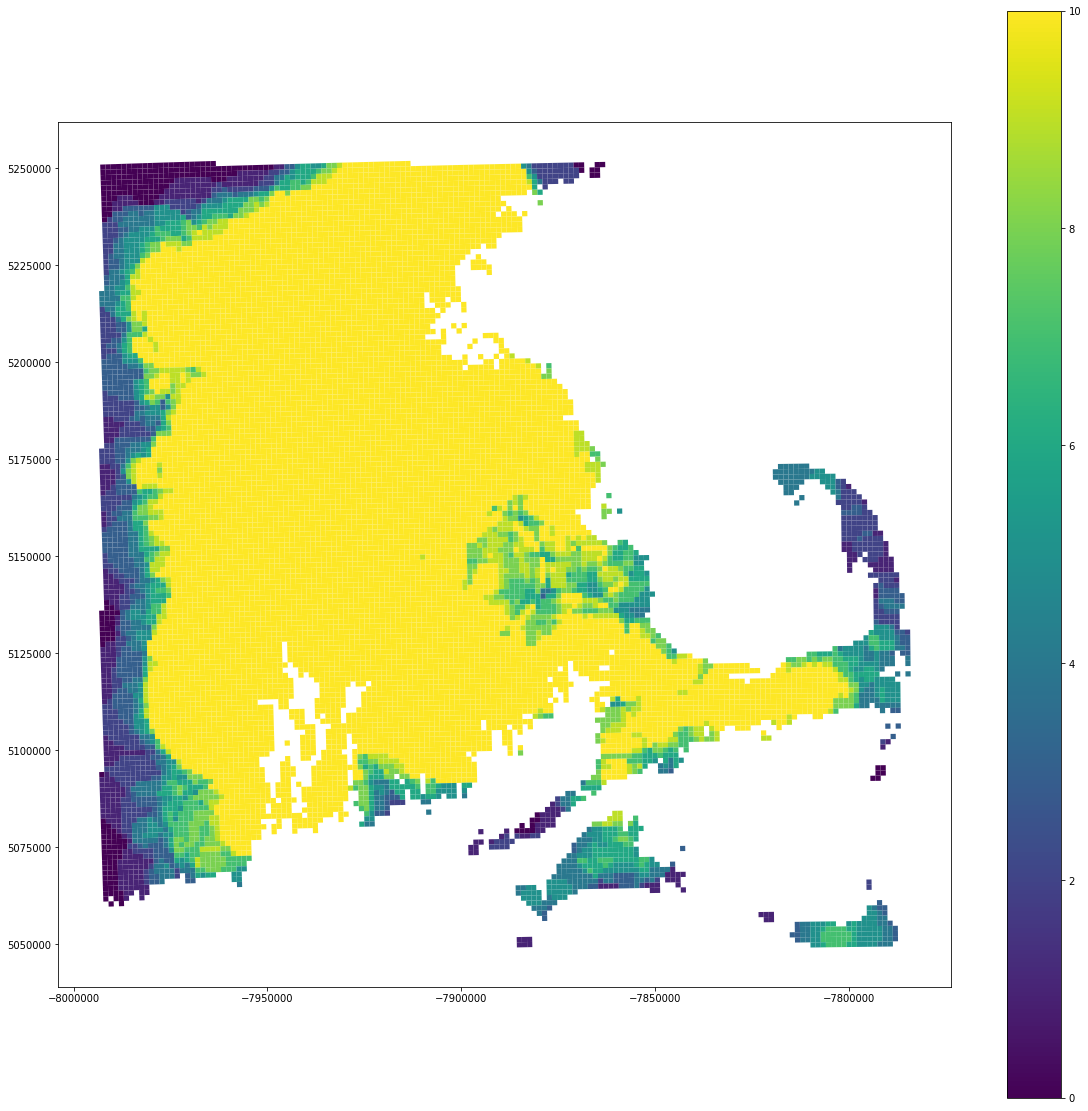

In [0]:
fig = plt.figure(figsize=[20,20])
ax = fig.add_subplot(111)
ax1 = game_grid.plot(ax=ax,column='eff health',legend=True)

In [0]:
game_grid.to_file('../../game/newresults.shp')

In [0]:
for k in hospital_squares:
  if(k[0] == 'h'):
    idx = int(''.join(i for i in k if i.isdigit()))
    if(hospitals.loc[idx, 'Large'] == True): 
      hospital_squares[k] = [hospital_squares[k], 2, 6000]
    else:
      hospital_squares[k] = [hospital_squares[k], 1, 3000]
  elif(k[0] == 's'):
    hospital_squares[k] = [hospital_squares[k], 1, 3000]
  else:
    idx = int(''.join(i for i in k if i.isdigit()))
    if(ems.loc[idx, 'Large'] == True): 
      hospital_squares[k] = [hospital_squares[k], 1, 1500]
    else:
      hospital_squares[k] = [hospital_squares[k], 1, 750]
budget = 2000000
hospital_squares_2 = hospital_squares.copy()
squares_times = [0 for i in range(game_grid.shape[0])]
hospital_indices = set()
shelter_indices = set()

while True:
  done = set()
  curr_max = max((len(v[0])*v[1], k) for k,v in hospital_squares_2.items())[1]
  for sq in hospital_squares_2[curr_max][0]:
    squares_times[sq]+=1
    if squares_times[sq] == 4:
      done.add(sq)
  budget-=hospital_squares_2[curr_max][2]
  del hospital_squares_2[curr_max]
  if budget < 0:
    break
  else:
    hospital_indices.add(curr_max)

  for plant in hospital_squares_2:
    new_set = hospital_squares_2[plant][0] - done
    hospital_squares_2[plant][0] = new_set
hospital_list = [int(i[8:]) for i in hospital_indices if i.startswith("hospital")]
ems_list = [int(i[3:]) for i in hospital_indices if i.startswith("ems")]
shelter_list = [int(i[7:]) for i in hospital_indices if i.startswith("shelter")]


In [0]:
hospital_indices

{'ems1',
 'ems10',
 'ems103',
 'ems104',
 'ems107',
 'ems11',
 'ems110',
 'ems112',
 'ems113',
 'ems114',
 'ems115',
 'ems116',
 'ems120',
 'ems122',
 'ems123',
 'ems124',
 'ems126',
 'ems128',
 'ems129',
 'ems13',
 'ems130',
 'ems131',
 'ems132',
 'ems134',
 'ems138',
 'ems139',
 'ems14',
 'ems140',
 'ems142',
 'ems143',
 'ems144',
 'ems145',
 'ems146',
 'ems147',
 'ems148',
 'ems149',
 'ems15',
 'ems150',
 'ems153',
 'ems155',
 'ems157',
 'ems158',
 'ems160',
 'ems162',
 'ems164',
 'ems166',
 'ems167',
 'ems169',
 'ems17',
 'ems170',
 'ems171',
 'ems172',
 'ems175',
 'ems179',
 'ems18',
 'ems181',
 'ems182',
 'ems185',
 'ems19',
 'ems190',
 'ems192',
 'ems193',
 'ems194',
 'ems195',
 'ems196',
 'ems197',
 'ems198',
 'ems199',
 'ems20',
 'ems201',
 'ems203',
 'ems204',
 'ems206',
 'ems207',
 'ems208',
 'ems210',
 'ems211',
 'ems212',
 'ems213',
 'ems214',
 'ems215',
 'ems216',
 'ems217',
 'ems218',
 'ems219',
 'ems22',
 'ems220',
 'ems223',
 'ems226',
 'ems230',
 'ems231',
 'ems232',


In [0]:
hospital_list

[53,
 46,
 50,
 38,
 54,
 68,
 69,
 26,
 65,
 15,
 4,
 9,
 13,
 22,
 0,
 7,
 34,
 24,
 64,
 40,
 12,
 45,
 10,
 43,
 66,
 63,
 52,
 59,
 48,
 30,
 47,
 11,
 23,
 51,
 61,
 35,
 44,
 3,
 31,
 25,
 62,
 32,
 6,
 49,
 36,
 14,
 28,
 20,
 27,
 55,
 39,
 42,
 57,
 8,
 21,
 67]

In [0]:
ems_list

[68,
 131,
 90,
 158,
 31,
 206,
 287,
 72,
 10,
 213,
 175,
 255,
 226,
 304,
 207,
 256,
 60,
 301,
 281,
 97,
 35,
 138,
 155,
 241,
 236,
 130,
 277,
 20,
 271,
 18,
 270,
 196,
 212,
 122,
 123,
 292,
 218,
 172,
 54,
 150,
 67,
 48,
 283,
 61,
 274,
 250,
 247,
 59,
 243,
 27,
 194,
 11,
 88,
 99,
 182,
 214,
 235,
 13,
 257,
 71,
 56,
 103,
 134,
 110,
 19,
 128,
 265,
 248,
 253,
 132,
 55,
 162,
 231,
 129,
 92,
 234,
 115,
 36,
 164,
 211,
 171,
 269,
 112,
 22,
 15,
 41,
 65,
 192,
 160,
 62,
 120,
 149,
 204,
 124,
 215,
 82,
 148,
 244,
 140,
 185,
 275,
 30,
 139,
 217,
 66,
 193,
 9,
 294,
 169,
 170,
 89,
 126,
 298,
 46,
 166,
 6,
 43,
 1,
 116,
 208,
 216,
 232,
 45,
 190,
 74,
 195,
 179,
 181,
 33,
 146,
 198,
 24,
 114,
 261,
 17,
 80,
 142,
 240,
 302,
 40,
 144,
 297,
 107,
 81,
 77,
 230,
 73,
 153,
 201,
 50,
 197,
 145,
 219,
 167,
 76,
 203,
 251,
 199,
 147,
 157,
 220,
 113,
 52,
 87,
 266,
 49,
 94,
 143,
 299,
 223,
 104,
 210,
 279,
 291,
 14,
 285,
 57]

In [0]:
shelter_list

[556,
 54,
 694,
 295,
 84,
 677,
 757,
 616,
 0,
 408,
 603,
 772,
 676,
 199,
 754,
 646,
 617,
 75,
 651,
 470,
 426,
 727,
 636,
 476,
 559,
 488,
 520,
 736,
 731,
 605,
 702,
 83,
 87,
 720,
 522,
 540,
 679,
 572,
 770,
 432,
 427,
 697,
 648,
 418,
 557,
 93,
 588,
 455,
 625,
 512,
 659,
 729,
 431,
 403,
 430,
 62,
 451,
 154,
 94,
 16,
 769,
 256,
 395,
 89,
 609,
 497,
 738,
 454,
 499,
 598,
 784,
 685,
 640,
 518,
 41,
 477,
 401,
 181,
 9,
 762,
 566,
 725,
 475,
 582,
 680,
 446,
 749,
 576,
 526,
 630,
 705,
 66,
 415,
 684,
 523,
 444,
 445,
 52,
 753,
 691,
 91,
 689,
 274,
 787,
 656,
 567,
 644,
 634,
 745,
 539,
 607,
 688,
 246,
 615,
 7,
 459,
 661,
 6,
 759,
 627,
 76,
 674,
 400,
 299,
 614,
 543,
 80,
 606,
 433,
 223,
 447,
 517,
 782,
 435,
 399,
 664,
 51,
 394,
 564,
 610,
 535,
 412,
 717,
 463,
 392,
 416,
 429,
 407,
 650,
 611,
 58,
 425,
 683,
 61,
 484,
 594,
 419,
 743,
 464,
 652,
 593,
 715,
 49,
 589,
 207,
 314,
 647,
 442,
 8,
 514,
 675,
 282

In [0]:
large_ems_list = ems.loc[ems_list].loc[ems['Large']]
small_ems_list = ems.loc[ems_list].loc[ems['Large'] == False]
small_hospital_list = hospitals.loc[hospital_list].loc[hospitals['Large'] == False]
large_hospital_list = hospitals.loc[hospital_list].loc[hospitals['Large']]

In [0]:
for idx, i in enumerate(shelters.loc[shelter_list, 'geometry'].buffer(3000)):
  e.loc[0, 'geometry'] = i
  m = gpd.sjoin(game_grid, e)
  hospital_squares['ems' + str(idx)] = set(m.index.to_list())
  m['health add'] = 1
  m = m.drop(labels=['kmSQ_ID', 'GZD', 'EASTING', 'NORTHING', 'MGRS_10km','Shape_Leng', 'Shape_Le_1', 'Shape_Area', 'x_centroid', 'y_centroid','elevation', 'population', 'Health', 'Utility', 'Transporta', 'index_right','geometry'],axis=1)
  game_grid['eff health'] += game_grid.merge(m,how='left',on='MGRS').fillna(0)['health add']
  m['health add'] = 0
for idx, i in enumerate(large_ems_list['geometry'].buffer(15000)):
  e.loc[0, 'geometry'] = i
  m = gpd.sjoin(game_grid, e)
  hospital_squares['ems' + str(idx)] = set(m.index.to_list())
  m['health add'] = 1
  m = m.drop(labels=['kmSQ_ID', 'GZD', 'EASTING', 'NORTHING', 'MGRS_10km','Shape_Leng', 'Shape_Le_1', 'Shape_Area', 'x_centroid', 'y_centroid','elevation', 'population', 'Health', 'Utility', 'Transporta', 'index_right','geometry'],axis=1)
  game_grid['eff health'] += game_grid.merge(m,how='left',on='MGRS').fillna(0)['health add']
  m['health add'] = 0
for idx, i in enumerate(small_ems_list['geometry'].buffer(10000)):
  e.loc[0, 'geometry'] = i
  m = gpd.sjoin(game_grid, e)
  hospital_squares['ems' + str(idx)] = set(m.index.to_list())
  m['health add'] = 1
  m = m.drop(labels=['kmSQ_ID', 'GZD', 'EASTING', 'NORTHING', 'MGRS_10km','Shape_Leng', 'Shape_Le_1', 'Shape_Area', 'x_centroid', 'y_centroid','elevation', 'population', 'Health', 'Utility', 'Transporta', 'index_right','geometry'],axis=1)
  game_grid['eff health'] += game_grid.merge(m,how='left',on='MGRS').fillna(0)['health add']
  m['health add'] = 0
for idx, i in enumerate(small_hospital_list['geometry'].buffer(15000)):
  e.loc[0, 'geometry'] = i
  m = gpd.sjoin(game_grid, e)
  hospital_squares['ems' + str(idx)] = set(m.index.to_list())
  m['health add'] = 2
  m = m.drop(labels=['kmSQ_ID', 'GZD', 'EASTING', 'NORTHING', 'MGRS_10km','Shape_Leng', 'Shape_Le_1', 'Shape_Area', 'x_centroid', 'y_centroid','elevation', 'population', 'Health', 'Utility', 'Transporta', 'index_right','geometry'],axis=1)
  game_grid['eff health'] += game_grid.merge(m,how='left',on='MGRS').fillna(0)['health add']
  m['health add'] = 0
for idx, i in enumerate(large_hospital_list['geometry'].buffer(25000)):
  e.loc[0, 'geometry'] = i
  m = gpd.sjoin(game_grid, e)
  hospital_squares['ems' + str(idx)] = set(m.index.to_list())
  m['health add'] = 2
  m = m.drop(labels=['kmSQ_ID', 'GZD', 'EASTING', 'NORTHING', 'MGRS_10km','Shape_Leng', 'Shape_Le_1', 'Shape_Area', 'x_centroid', 'y_centroid','elevation', 'population', 'Health', 'Utility', 'Transporta', 'index_right','geometry'],axis=1)
  game_grid['eff health'] += game_grid.merge(m,how='left',on='MGRS').fillna(0)['health add']
  m['health add'] = 0
game_grid.loc[game_grid['eff health'] > 10, 'eff health']= 10

/usr/local/lib/python3.6/dist-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!(EPSG:3785 != None)
  '(%s != %s)' % (left_df.crs, right_df.crs))


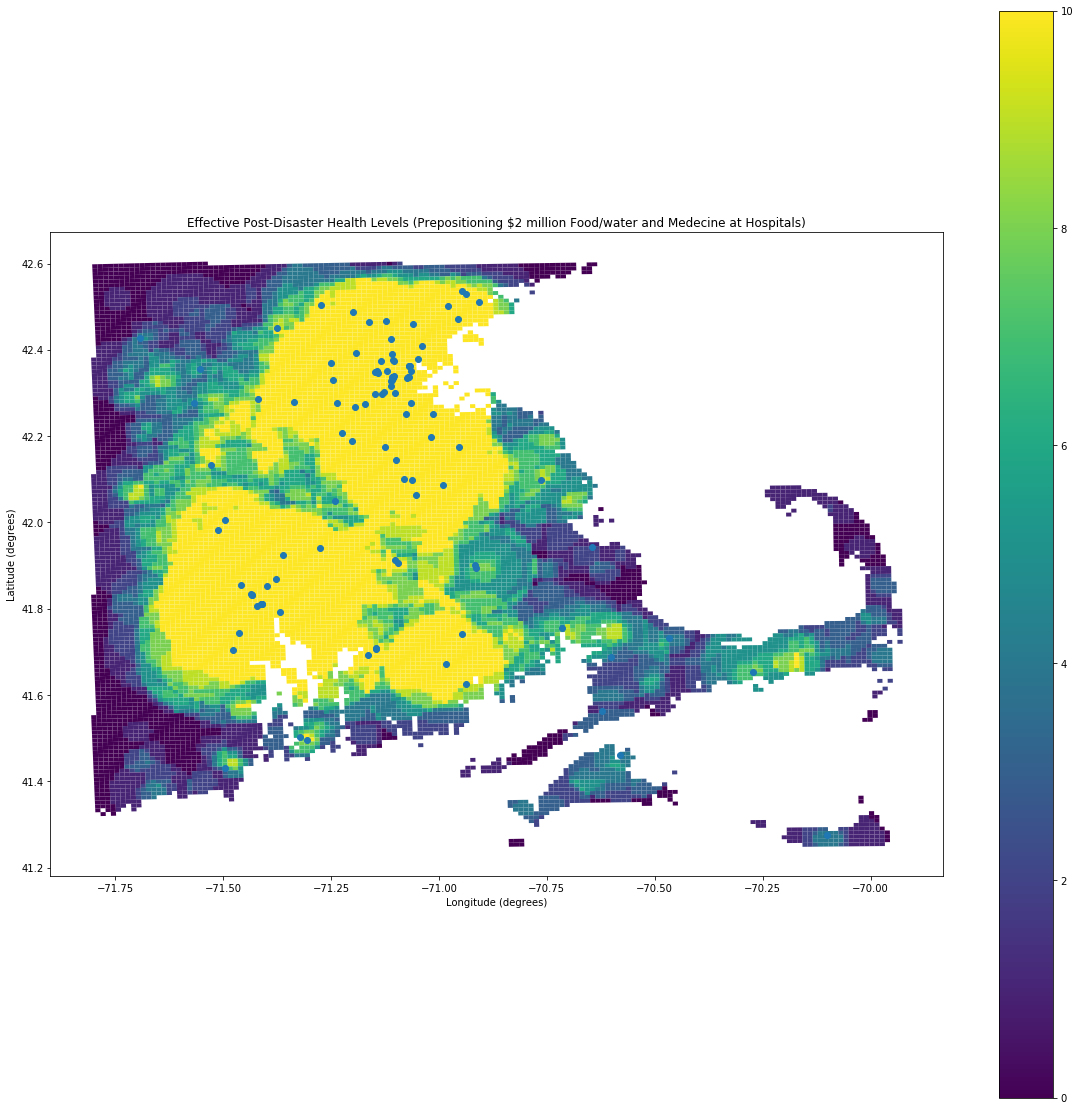

In [0]:
fig = plt.figure(figsize=[20,20])
ax = fig.add_subplot(111)
ax.set_title('Effective Post-Disaster Health Levels (Prepositioning $2 million Food/water and Medecine at Hospitals)')
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')
fig.set_facecolor('white')
ax1 = game_grid.to_crs(epsg=4326).plot(ax=ax, column='eff health', legend=True)
ax2 = hospitals.to_crs(epsg=4326).plot(ax=ax)

In [50]:
shortest_path_matrix = []
relabel_dict = {}
for idx, i in enumerate(power_plant_indices):
  relabel_dict[idx] = i
  temparr = []
  for jdx, j in enumerate(power_plant_indices):
    temparr.append(powerplants.loc[i, 'geometry'].distance(powerplants.loc[j,'geometry']))
    if temparr[-1] == 0: temparr[-1] = float('inf')
  shortest_path_matrix.append(temparr)
shortest_path_matrix = np.array(shortest_path_matrix)
shortest_path_matrix

array([[            inf,  39244.35119025, 162306.59802272, ...,
         59855.46220711, 101396.97510576,  38884.15895313],
       [ 39244.35119025,             inf, 193767.01983358, ...,
         57620.40851369, 131729.4006366 ,  78097.53910881],
       [162306.59802272, 193767.01983358,             inf, ...,
        154554.57032246,  62054.35949296, 136967.85892991],
       ...,
       [ 59855.46220711,  57620.40851369, 154554.57032246, ...,
                    inf,  95087.33662089,  84379.57372168],
       [101396.97510576, 131729.4006366 ,  62054.35949296, ...,
         95087.33662089,             inf,  81490.74373399],
       [ 38884.15895313,  78097.53910881, 136967.85892991, ...,
         84379.57372168,  81490.74373399,             inf]])

In [0]:
print(max(shortest_path_matrix.flatten()))

inf


In [51]:
power_plant_indices.remove(52)
power_plant_indices.remove(24)

KeyError: ignored

In [0]:
groups = []
seen = set()
for idx, i in enumerate(shortest_path_matrix):
  if idx in seen: continue
  arr = [idx, np.argmin([k if idx not in seen else float("inf") for idx, k in enumerate(i)])]
  seen.add(idx)
  seen.add(arr[1])
  groups.append(arr)
actual_indices = [[relabel_dict[i] for i in j] for j in groups]

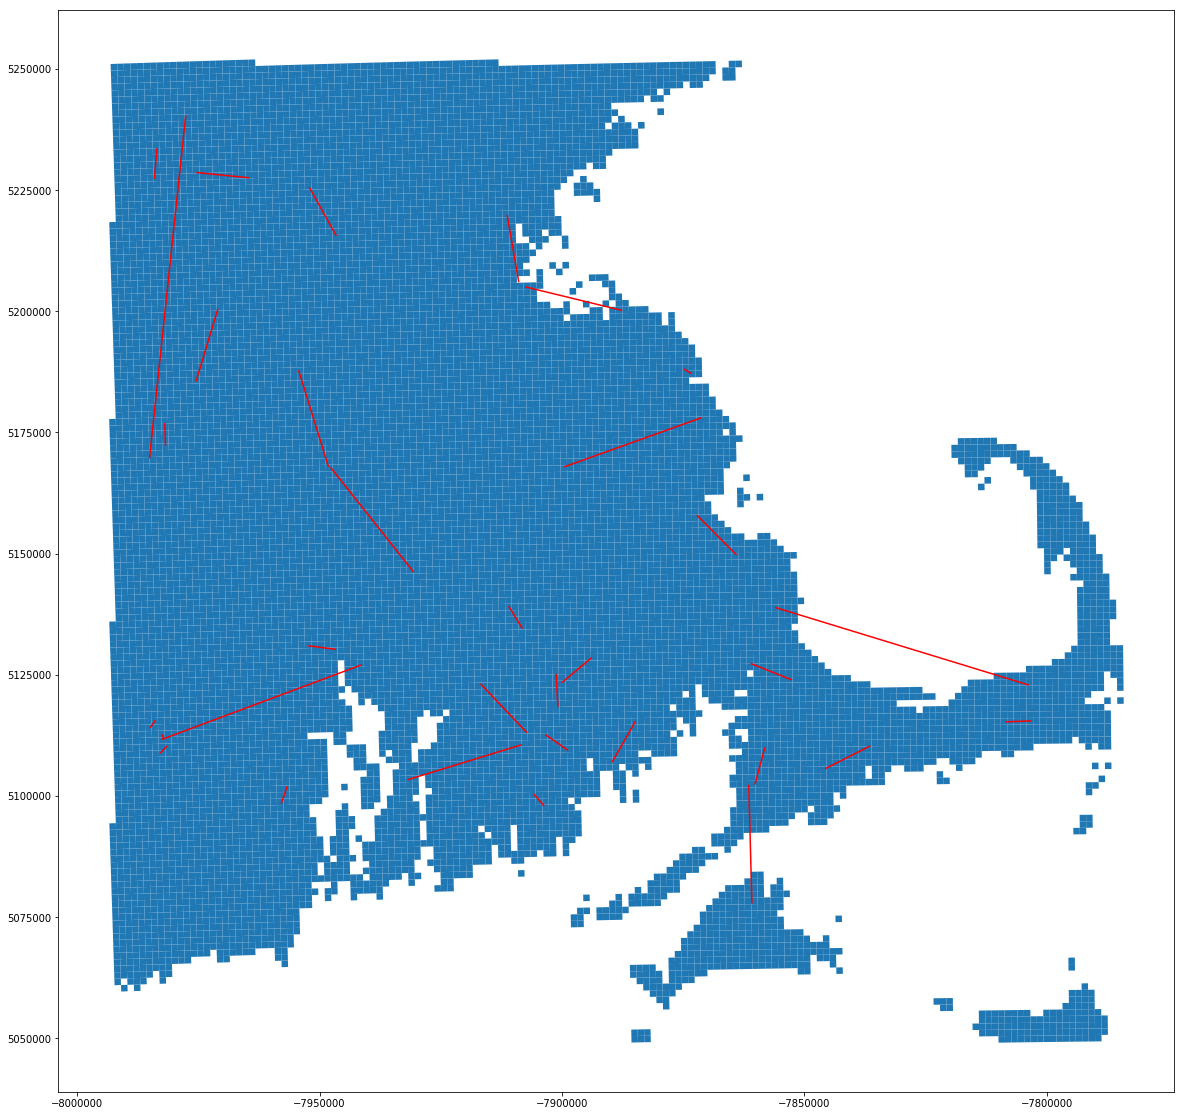

In [58]:
fig = plt.figure(figsize=[20,20])
centroids = []
centroids_indices = []
ax = fig.add_subplot(111)
tuple_indices = []
ax1 = game_grid.plot(ax=ax)
for i in actual_indices:
  tuple_indices.append(tuple(i))
  l = LineString(tuple([powerplants.loc[i[0],'geometry'],powerplants.loc[i[1],'geometry']]))
  lx, ly = l.xy
  centroids.append(l.centroid)
  centroids_indices.append(i.copy())
  ax.plot(lx, ly, 'r-')

#ax.plot(lstr.xy[0], lstr.xy[1],'r-')

In [0]:
dists = [base['geometry'].distance(i) for i in centroids]
nodes = [power_plants_squares[centroids_indices[idx][0]] | power_plants_squares[centroids_indices[idx][1]] for idx, i in enumerate(centroids)]

In [60]:
budget = 32
power_plants_squares_2 = power_plants_squares.copy()
squares_times = [0 for i in range(game_grid.shape[0])]
nodes_2 = nodes.copy()
new_power_plants = []
while True:
  done = set()
  curr_max = max((len(i)/dists[idx], idx) for idx,i in enumerate(nodes_2))[1]
  for sq in nodes_2[curr_max]:
    squares_times[sq]+=1
    if squares_times[sq] == 3:
      done.add(sq)
  nodes_2[curr_max] = set()
  budget-=1
  if budget < 0:
    break
  else:
    new_power_plants.append(centroids_indices[curr_max])

  for idx, plant in enumerate(nodes_2):
    new_set = nodes_2[idx] - done
    nodes_2[idx] = new_set



ValueError: ignored

In [0]:
print(list(powerplants.loc[list(itertools.chain.from_iterable(new_power_plants)),'OBJECTID']),sep='')

In [31]:
airfields = airfields.set_index('objectid')

KeyError: ignored

In [35]:
airfields.loc[[7690, 7661, 7519, 7650, 7695]]



,facilityty,stateabbv,city,geometry
objectid,,,,
7690,Airport,MA,Stow,POINT Z (-71.51783147154515 42.46064038884293 0)
7661,Airport,MA,Plymouth,POINT Z (-70.72877777827182 41.90902777780974 0)
7519,Airport,MA,Bedford,POINT Z (-71.28900000034969 42.46994444468044 0)
7650,Airport,MA,Norwood,POINT Z (-71.17294444453046 42.19052777753495 0)
7695,Airport,MA,Taunton,POINT Z (-71.01631649980658 41.87446738915872 0)


In [32]:
airfields

,facilityty,stateabbv,city,geometry
objectid,,,,
7516,Heliport,MA,Barnstable,POINT Z (-70.41530277800075 41.61149916665329 0)
7519,Airport,MA,Bedford,POINT Z (-71.28900000034969 42.46994444468044 0)
7522,Airport,MA,Berkley,POINT Z (-71.02647222171561 41.8390555556694 0)
7523,Seaplane Base,MA,Berkley,POINT Z (-71.11472222195295 41.82055555509487 0)
7524,Airport,MA,Berlin,POINT Z (-71.64173416709809 42.36759305587486 0)
7527,Heliport,MA,Beverly,POINT Z (-70.81255555519465 42.55797222244018 0)
7528,Airport,MA,Boston,POINT Z (-71.00642380531434 42.36296502771393 0)
7529,Heliport,MA,Boston,POINT Z (-71.06913055573051 42.36366944508887 0)
7530,Heliport,MA,Boston,POINT Z (-71.05088361088991 42.31815361060069 0)


In [36]:
airfields.reset_index()

,objectid,facilityty,stateabbv,city,geometry
0,7516,Heliport,MA,Barnstable,POINT Z (-70.41530277800075 41.61149916665329 0)
1,7519,Airport,MA,Bedford,POINT Z (-71.28900000034969 42.46994444468044 0)
2,7522,Airport,MA,Berkley,POINT Z (-71.02647222171561 41.8390555556694 0)
3,7523,Seaplane Base,MA,Berkley,POINT Z (-71.11472222195295 41.82055555509487 0)
4,7524,Airport,MA,Berlin,POINT Z (-71.64173416709809 42.36759305587486 0)
5,7527,Heliport,MA,Beverly,POINT Z (-70.81255555519465 42.55797222244018 0)
6,7528,Airport,MA,Boston,POINT Z (-71.00642380531434 42.36296502771393 0)
7,7529,Heliport,MA,Boston,POINT Z (-71.06913055573051 42.36366944508887 0)
8,7530,Heliport,MA,Boston,POINT Z (-71.05088361088991 42.31815361060069 0)
9,7531,Heliport,MA,Boston,POINT Z (-71.13255277708896 42.36509694436853 0)
